In [1]:
# import of necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


pd.options.mode.chained_assignment = None


In [2]:
# load data
df = pd.read_csv('data/high_diamond_ranked_10min.csv')

### 1. Problem Formulation

The objective of this project is to develop a Bayesian predictive model for League of Legends (LoL) games. LoL is a popular multiplayer online battle arena (MOBA) game developed and published by Riot Games. In this game, two teams (blue and red one) of five players compete against each other in an effort to destroy the opponent's Nexus - the core building located in the heart of the opposing team's base.

As the problem requires some expert knowledge, therefore we provide brief summary of LoL game rules and features necessary that we believe that are necessary to understand the analysis.

- Gold: In LoL, gold is the primary resource used to purchase items. Items can enhance a champion's stats, grant them new abilities, and generally make them more powerful. Players earn gold in a variety of ways, including killing enemy champions, minions, and neutral monsters, and destroying enemy structures.

- Experience (XP): Experience points, or XP, is another crucial resource in the game. Players earn XP by being near enemy minions or monsters when they die, or by killing or assisting in killing enemy champions. When a champion earns enough XP, they level up, increasing their base stats and allowing them to unlock or upgrade one of their abilities.

- Kills: A kill is awarded to a player when they land the final blow that results in the death of an enemy champion.

- Assists: An assist is awarded to a player if they contributed to the death of an enemy champion but did not land the final blow. Assists still grant gold and experience, albeit less than kills.

- Deaths: A death occurs when a champion's health reaches zero. Upon death, a champion respawns back at their base after a certain amount of time, which increases as the game progresses.

- Epic Monsters: Epic monsters are powerful neutral creatures that provide significant benefits when killed. They include the Dragon, Baron Nashor, and Rift Herald. Killing these monsters grants the team various buffs, bonus gold, and experience.

- Towers: Towers, also known as turrets, are powerful defensive structures that guard the three main paths (or lanes) to each team's base. They attack enemy champions and minions that come within range and provide a significant obstacle to attacking teams. Destroying a tower grants gold to the team and pushes the lane closer to the enemy base.

- Minions: Minions are AI-controlled units that spawn at the nexus and advance along the three lanes toward the enemy base. They attack enemy champions, minions, and towers, and killing them provides gold and experience. The constant flow of minions is a primary mechanism driving the game forward and forcing player interaction.


We assume that the games are independent of each other. That is, the outcome of a game only depends on the statistics of that game and not any other games.
We are ignoring in-game factors that could change over time, such as patch updates, new champion releases, etc., which could affect the game's outcome.

**The aim of the project is to predict the result (winner) of the game based on statistics of each team after 10 minutes of the game.**

We claim our model may be useful. Predicted **use-cases** of proposed model are desbribed below.

- E-Sports Betting This model could be used by individuals involved in e-sports betting to better predict game outcomes and make more informed bets.

- Performance Analysis Teams could use this analysis to identify what factors in the first 10 minutes of a game are most predictive of success. This can guide their training and strategies for future games.

- Player Improvement Individual players could use this analysis to understand what factors in the first 10 minutes of a game are important for winning, allowing them to improve their gameplay.

- Game Development For the game developers, these insights could guide balanced gameplay, champion design, and other game development decisions. They could use this to identify if early game events are disproportionately affecting the game's outcome and need to be rebalanced.

**Data source.**

Data has been downloaded from kaggle. 

https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min  

Dataset cosist of 40 columns and 9879 rows.

Exact column names are depicted in section 1.1.

Beside gameId and result (Blue wins) all collumns are divided into statistics of opposite teams: blue and red ones.
Distinc features describe:

- wards (blueWins, blueWardsPlaced, blueWardsDestroyed) - we do not use this data in further analysis

- ... [TODO]

**DAG** is depicted in section 1.2.


Pipes (Causal Chains):

- epicMonstersDifference -> experienceDifference -> gameResult
- epicMonstersDifference -> goldDifference -> gameResult
- minionsDifference -> experienceDifference -> gameResult
- minionsDifference -> goldDifference -> gameResult
- towersDifference -> goldDifference -> gameResult
- DAKDA -> experienceDifference -> gameResult
- DAKDA -> goldDifference -> gameResult

Forks (Common Cause):

- epicMonstersDifference causing changes in experienceDifference and goldDifference.
- minionsDifference causing changes in experienceDifference and goldDifference.
- DAKDA causing changes in experienceDifference and goldDifference.

Colliders (Common Effect):

- experienceDifference and goldDifference both causing changes in gameResult.


#### EDA

In [ ]:
onlyBlueCols = [c for c in df.columns if 'blue' in c.lower()]
plt.figure(figsize=(12, 12))
sns.heatmap(df[onlyBlueCols].corr(), annot=True, fmt=".2f")
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(df[onlyBlueCols].corr(), annot=True, fmt=".2f")
plt.show()

In [ ]:
sns.jointplot(data=df, x="blueDeaths", y="blueKills", hue="blueWins")
plt.show()

#### 1.1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

#### 1.2

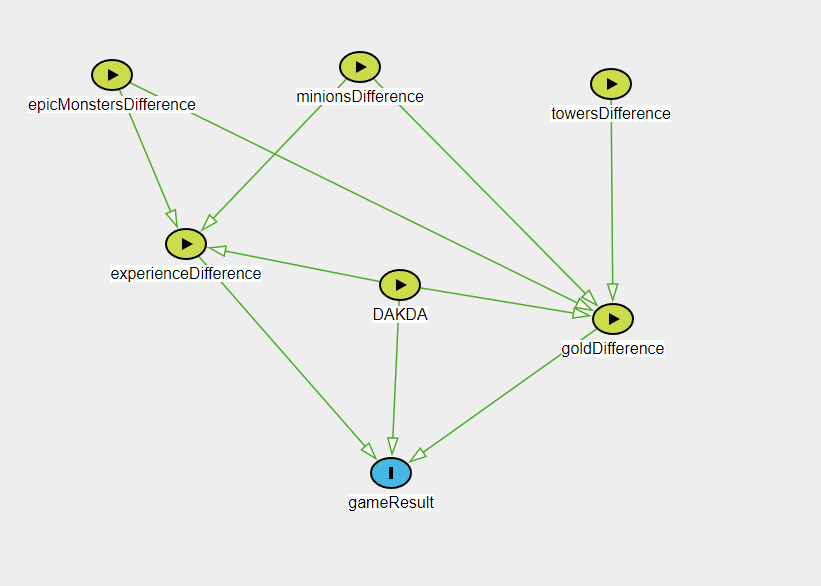

### 2. Data Preprocessing

We have dropped all the rows what contained NaNs (0).

We conclued that in game it does not matter whether team is good by any measure but the difference in these features is what matters the most, therefore we made features differential. This process code is provided in section 2.1.

Our Bayesian model will incorporate the following difference variables, comparing the stats of both teams:

Team Gold Difference: The difference in the total amount of gold earned by each team. Gold is earned by killing enemy champions, minions, and neutral monsters and is used to buy items to strengthen champions.

Team Experience Difference: The difference in total experience points earned by each team. Experience points are crucial for leveling up the champions and unlocking and strengthening their abilities.

Difference Augmented KDA: KDA stands for Kills, Deaths, and Assists. We'll look at the difference between the KDA ratios of each team, a measure of overall team performance in fights.

Minions Difference: The difference in the total number of minions (non-player characters that are a primary source of gold and experience) killed by each team.

Epic Monster Difference: The difference in the number of epic monsters (highly powerful neutral monsters that grant significant benefits when killed) each team has slain.

Towers Destroyed Difference: The difference in the number of towers (defensive structures that guard the main paths towards the nexus) each team has destroyed.

These difference variables provide a quantifiable measure of each team's advantage over the other after the first 10 minutes of the game, which we can use to predict the eventual game outcome.


We scale data (subtract mean and divide by std) as we came across issues HMC sampler convergence. Exact code can be found in secion 2.2.



#### 2.1

In [ ]:
features = df[['blueWins']]

features["goldDiff"] = df["blueGoldDiff"]
features["expDiff"] = df["blueExperienceDiff"]
features["KDDiff"] = df["blueKills"] - df["blueDeaths"]
features["DAKDA"] = (df["blueKills"] + df["blueAssists"]) * df["redDeaths"] - (df["redKills"] + df["redAssists"]) * df["blueDeaths"]
features["ADiff"] = df["blueAssists"] - df["redAssists"]
features["EMDiff"] = df["blueEliteMonsters"] - df["redEliteMonsters"]
features["TowersDiff"] = df["blueTowersDestroyed"] - df["redTowersDestroyed"]
features["MinionsDiff"] = df["blueTotalMinionsKilled"] - df["redTotalMinionsKilled"]

plt.figure(figsize=(12, 12))
sns.heatmap(features.corr(), annot=True, fmt=".2f")
plt.show()

#### 2.2

In [ ]:
scaler = StandardScaler()

X = features[['goldDiff', 'expDiff']]
y = features['blueWins'].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=28062023)

scaler.fit(X_train)
X_train = scaler.transform(X_train)

#### EDA

sns.jointplot(data=features, x="goldDiff", y="expDiff", hue="blueWins")
plt.show()

### 3. Model


#### First Model (Logit Model)

The model have three distinct predictors:

- DAKDA
- 
- 

#### Second Model (Probit Model)

The second Model [TODO] ...

Models do cleraly differ on the following matters:


Difference has been applied due to a fact that ...





### 4. Priors

We have chosen ...

### 5. Posterior analysis First Model

### 6. Posterior analysis Second Model

### 7. Model comparison